In [ ]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
# 디바이스 할당
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# 라이브러리 임포트
import torchvision.datasets as datasets
trans_to_train = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(0.5,0.5),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.RandomErasing(p=0.5, scale=(0.02,0.33), ratio=(0.5,2))])
trans_to_test = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(0.5,0.5)])
# 이미지 뒤집기 좌우대칭
# trans = transforms.Compose([transforms.ToTensor(),
#                             transforms.RandomHorizontalFlip(p=0.5)])
# 이미지 뒤집기 상하대칭
# trans = transforms.Compose([transforms.ToTensor(),
#                             transforms.RandomVerticalFlip(p=0.5)])
# 이미지 삭제하기
# trans = transforms.Compose([transforms.ToTensor(),
#                             transforms.RandomErasing(p=0.5, scale=(0.02,0.33), ratio=(0.5,2))])
# 이미지 잘라내기
# trans = transforms.Compose([transforms.ToTensor(),
#                             transforms.RandomResizedCrop((32,32), scale = (0.1,1), ratio = (0.5,2))])
# 이미지 밝기 대비 채도 색조 변경하기
# trans = transforms.Compose([transforms.ToTensor(),
#                             transforms.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5, hue=0.5)])
                            

data_root = './data'
train_set = datasets.CIFAR10(
    root = data_root, train = True,
    download=True, transform = trans_to_train)

test_set = datasets.CIFAR10(
    root = data_root, train = False,
    download=True, transform = trans_to_test)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size = 100

train_loader = DataLoader(
    train_set, batch_size= batch_size,
    shuffle = True
)

test_loader = DataLoader(
    test_set, batch_size= batch_size,
    shuffle = False
)

In [ ]:
classes = train_set.classes

In [ ]:
plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)
    
    # image와 label 취득
    image, label = train_set[i]
    
    # 이미지 출력
    plt.imshow(np.transpose(image,(1,2,0)))
    ax.set_title(f'{classes[label]}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        # 배치 정규화
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), # in_channels : 인풋값 , out_channels : 아웃풋값
            self.bn1,
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            self.bn2,
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2), # 과적합을 막기위한 Dropout, nn.Dropout(드랍비율)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            self.bn3,
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            self.bn4,
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            self.bn5,
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            self.bn6,
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4)
        )

        self.l1 = nn.Linear(in_features=128*4*4,out_features=128)
        self.l2 = nn.Linear(in_features=128,out_features=len(classes))

        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.4)
    def forward(self, x):
        x = self.layer1(x)

        x = x.view(x.size(0),-1)

        x = self.l1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.l2(x)
        return x

In [ ]:
# 난수 고정
torch.cuda.manual_seed(123)

model1 = CNN1()
model1.to(device)
lr = 1e-3
optimizer = torch.optim.Adam(model1.parameters(), lr=lr)

In [ ]:
# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

In [ ]:
history_m1= np.zeros((0,5))

In [ ]:
num_epochs = 30
# tqdm 라이브러리 임포트
from tqdm.notebook import tqdm
for epoch in range(num_epochs):
  train_acc_m1, train_loss_m1 = 0, 0
  test_acc_m1, test_loss_m1 = 0, 0
  n_train, n_test = 0, 0

  for images, labels in tqdm(train_loader):
    n_train += len(labels)

    inputs = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model1(inputs)
    loss_model1 = criterion(outputs, labels)
    loss_model1.backward()
    optimizer.step()
    pred_m1 = outputs.max(axis=1)[1]
    train_loss_m1 += loss_model1.item()
    train_acc_m1 += (pred_m1 == labels).sum().item()
  for images_test, labels_test in test_loader:
    n_test += len(labels_test)

    inputs_test = images_test.to(device)
    labels_test = labels_test.to(device)

    outputs_test = model1(inputs_test)

    loss_test_model1 = criterion(outputs_test, labels_test)

    pred_test_m1 = outputs_test.max(axis=1)[1]

    test_loss_m1 +=  loss_test_model1.item()
    test_acc_m1 +=  (pred_test_m1 == labels_test).sum().item()
  
  train_acc_m1 = train_acc_m1 / n_train
  test_acc_m1 = test_acc_m1 / n_test
  train_loss_m1 = train_loss_m1 / n_train
  test_loss_m1 = test_loss_m1 / n_test
  print(f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss_m1:.5f}, loss_test: {test_loss_m1:.5f}')
  item = np.array([epoch+1 , train_loss_m1, train_acc_m1, test_loss_m1, test_acc_m1])
  history_m1 = np.vstack((history_m1, item))

In [ ]:
# 손실과 정확도 확인

print(f'초기상태 : 손실 : {history_m1[0,3]:.5f}  정확도 : {history_m1[0,4]:.5f}' )
print(f'최종상태 : 손실 : {history_m1[-1,3]:.5f}  정확도 : {history_m1[-1,4]:.5f}' )

초기상태 : 손실 : 0.01262  정확도 : 0.54020
최종상태 : 손실 : 0.00573  정확도 : 0.81340


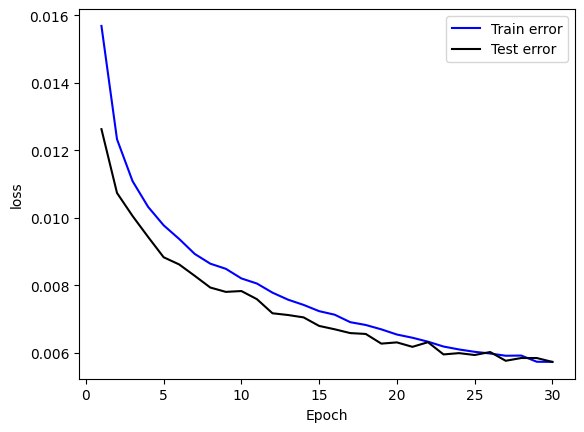

In [ ]:
# 학습 곡선 출력(손실)

plt.plot(history_m1[:,0], history_m1[:,1], 'b', label='Train error')
plt.plot(history_m1[:,0], history_m1[:,3], 'k', label='Test error')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

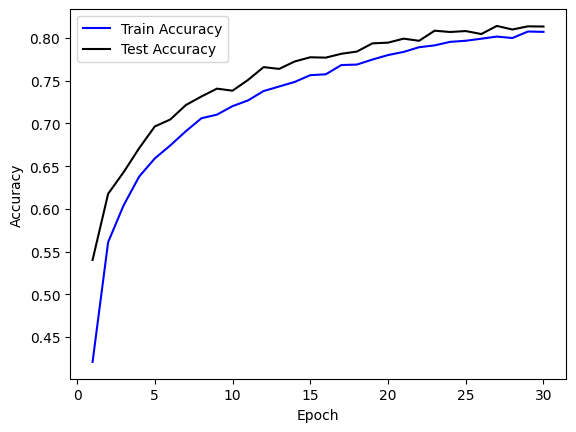

In [ ]:
# 학습 곡선 출력(정확도)

plt.plot(history_m1[:,0], history_m1[:,2], 'b', label='Train Accuracy')
plt.plot(history_m1[:,0], history_m1[:,4], 'k', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()